### Team Member
    Alan Xing ID: 101144347
    Chien-I Chao ID: 101135366
    Nicholas Rasmussen ID: 1839739

GitHub Link : https://github.com/Sup3000gt/Machine-Learning-Project

<center>

### Convolutional Neural Network Project


</center>


In [58]:
# import all libraries

from ucimlrepo import fetch_ucirepo 
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, SpatialDropout2D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#### Step 1.1 Loading the Dataset 

In [59]:
# Using the code from ucimlrepo directly load the data

optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 

#### Let's look at the data

In [60]:
print(X.shape)

(5620, 64)


In [61]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0


In [62]:
y.head()

,class
0,0
1,0
2,7
3,4
4,6


#### Step 1.2 Preprocessing - Normalization
Here we normalize all values between zero and one, as is standard for neural network processing

In [63]:
max_pixel_value = X.max().max()
print("Maximum pixel value:", max_pixel_value)

# seem like the Max value of pixel is 16 instead of 255 like other image, we will normalize data base on this
X_normalized = X / max_pixel_value

Maximum pixel value: 16


In [64]:
# after Normalization
X_normalized.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64
0,0.0,0.0625,0.3750,0.9375,0.7500,0.0625,0.0,0.0,0.0,0.4375,...,0.0000,0.0,0.0,0.0,0.3750,0.8750,0.4375,0.0625,0.0,0.0
1,0.0,0.0000,0.6250,1.0000,0.3750,0.0000,0.0,0.0,0.0,0.4375,...,0.1875,0.0,0.0,0.0,0.6250,1.0000,0.9375,0.1875,0.0,0.0
2,0.0,0.0000,0.5000,0.9375,1.0000,0.8125,0.0,0.0,0.0,0.0625,...,0.0000,0.0,0.0,0.0,0.5625,0.8750,0.0000,0.0000,0.0,0.0
3,0.0,0.0000,0.0000,0.1875,0.6875,1.0000,0.0,0.0,0.0,0.0000,...,0.0000,0.0,0.0,0.0,0.0000,0.0625,0.9375,0.1250,0.0,0.0
4,0.0,0.0000,0.3125,0.8750,0.2500,0.0000,0.0,0.0,0.0,0.0000,...,0.7500,0.0,0.0,0.0,0.2500,0.7500,0.8750,0.4375,0.0,0.0


#### Step 1.2 Preprocessing - Reshape
Here we add the channels dimension to all of our data points

In [65]:

"""
current shape is 8 x 8 array, (64) we need to reshape it into 2D array
"""
# Data frame do not have reshape, so we will convert into numpy array first
X_np = X_normalized.to_numpy()

X_reshaped = X_np.reshape(-1, 8, 8, 1)  # Reshape to (5620, 8, 8, 1)

print("Reshaped data shape:", X_reshaped.shape)


Reshaped data shape: (5620, 8, 8, 1)


In [66]:
# convert y to numpy array as well
y = y.to_numpy()

#### Step 1.2 Preprocessing - Data Split
Here we split the data

In [67]:
# Now we are ready to split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

#### Step 1.3 and 1.4 Data Augmentation and One-Hot Encoding
Here we add Gaussian noise to the training set while also doubling it. Then use a categorical representation for the label data

In [68]:
# Create a function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, std=0.05):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip values to [0, 1]

# Create a larger training set by adding noise to each image
X_train_augmented = []
y_train_augmented = []

for i in range(2):
    for i in range(len(X_train)):
        original_image = X_train[i]
        noisy_image = add_gaussian_noise(original_image)
        X_train_augmented.append(noisy_image)
        y_train_augmented.append(y_train[i])

# Convert lists to numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# One-hot encode the labels
y_train_augmented_onehot = to_categorical(y_train_augmented, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

### Step 2/3/4 CNN Architecture/ Max Pooling/ Softmax
Here, we create our Convolutional Neural Network. All output dimension sizes have been documented. Parameters are in the model summary before training

In [71]:
def cnet(input_shape=(8,8,1), num_classes=10, dropout_rate=0.2):
    # Define the input layer
    inputs = Input(shape=input_shape) #Outputs a (8,8,1) matrix

    # Define the encoder part
    x = Conv2D(32, 3, padding="same")(inputs) #Outputs a (8,8,32) matrix
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2), padding="same")(x) #Outputs a (4,4,32) matrix, halving the spatial dimensions
    x = SpatialDropout2D(dropout_rate)(x)   #We also use spatial dropout to remove feature maps for regularization

    x = Conv2D(64, 3, padding="same")(x) #Outputs a (4,4,64) matrix
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2), padding="same")(x) #Outputs a (2,2,64) matrix
    x = Dropout(dropout_rate)(x)  #Normal dropout that drop neurons to zero

    x = Conv2D(128, 3, padding="same")(x) #Outputs a (2,2,128) matrix
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Flatten()(x) #Outputs a 512 sized sector from the dimensions 2x2x128
    x = Dropout(dropout_rate)(x)  #Normal dropout that drop neurons to zero

    x = Dense(64)(x) #Outputs a 64 sized sector
    x = Dropout(dropout_rate)(x)  #Normal dropout that drop neurons to zero

    # Define the output layer
    outputs = Dense(num_classes, activation="softmax")(x) #Outputs a vector of size 10 representing the ratio of probabilities across a distribution of classes

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [72]:
#code found online for reinitializing the weights of a model in a method
def reset_weights(model):
  for layer in model.layers:
    if isinstance(layer, Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

model = cnet()

# Compile our model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 32)          320       
                                                                 
 batch_normalization_12 (Ba  (None, 8, 8, 32)          128       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 8, 8, 32)          0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_4 (Spati  (None, 4, 4, 32)          0   

#### Step 5. Model Performance - Training

In [73]:
reset_weights(model)
history = model.fit(
    X_train_augmented, y_train_augmented_onehot, 
    epochs=20, 
    validation_data=(X_test, y_test_onehot)
)

Epoch 1/20


c:\users\nick_\appdata\local\programs\python\python38\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


281/281 [==============================] - 2s 4ms/step - loss: 0.4845 - accuracy: 0.8429 - val_loss: 0.6839 - val_accuracy: 0.8657
Epoch 2/20
281/281 [==============================] - 1s 4ms/step - loss: 0.1448 - accuracy: 0.9513 - val_loss: 0.1023 - val_accuracy: 0.9662
Epoch 3/20
281/281 [==============================] - 1s 4ms/step - loss: 0.0866 - accuracy: 0.9698 - val_loss: 0.0511 - val_accuracy: 0.9858
Epoch 4/20
281/281 [==============================] - 1s 4ms/step - loss: 0.0839 - accuracy: 0.9729 - val_loss: 0.0463 - val_accuracy: 0.9893
Epoch 5/20
281/281 [==============================] - 1s 4ms/step - loss: 0.0618 - accuracy: 0.9793 - val_loss: 0.0612 - val_accuracy: 0.9840
Epoch 6/20
281/281 [==============================] - 1s 4ms/step - loss: 0.0627 - accuracy: 0.9806 - val_loss: 0.0271 - val_accuracy: 0.9911
Epoch 7/20
281/281 [==============================] - 1s 4ms/step - loss: 0.0540 - accuracy: 0.9835 - val_loss: 0.0411 - val_accuracy: 0.9902
Epoch 8/20
281/28

#### Step 5.1 Model Performance with Accuracy plot, Loss plot, and Confusion matrix
- As we can see above, our model performance is close to 99%, let's visualize the results of our model

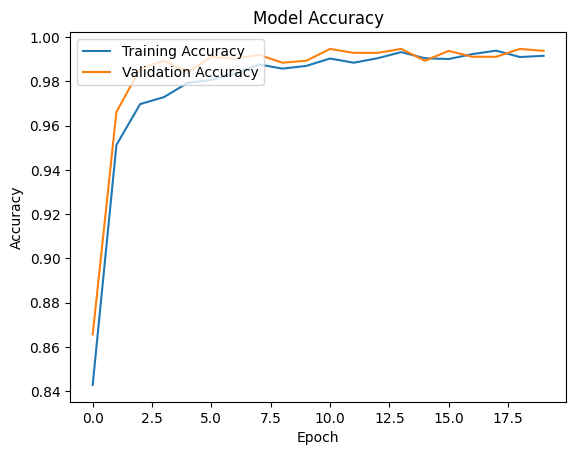

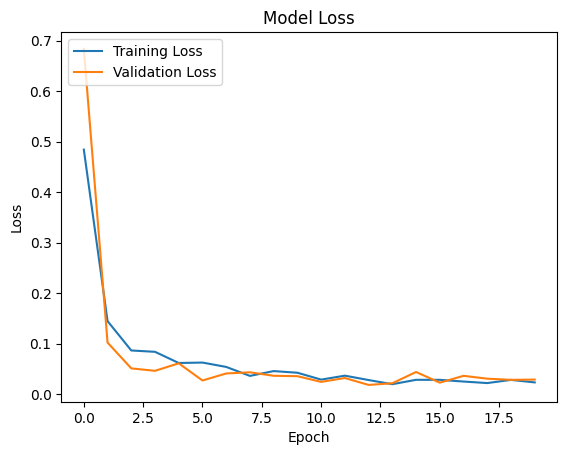

36/36 [==============================] - 0s 1ms/step


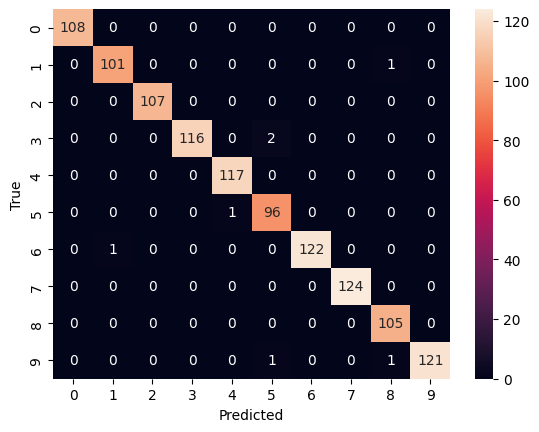

In [74]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(to_categorical(y_test, num_classes=10), axis=1)
    
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#### Step 5.2 K-Fold cross-validation
- Here, we implmenet K-Fold cross-validation. We also collect pertenant metrics for each class across all folds.

In [75]:
# Initialize lists to store metrics across folds
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
f1_scores = []

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_reshaped):
    reset_weights(model)
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Create a larger training set by adding noise to each image
    X_train_augmented = []
    y_train_augmented = []
    y_test_one = to_categorical(y_test, num_classes=10)
    
    for i in range(2):
        for i in range(len(X_train)):
            original_image = X_train[i]
            noisy_image = add_gaussian_noise(original_image)
            X_train_augmented.append(noisy_image)
            y_train_augmented.append(y_train[i])
    
    # Convert lists to numpy arrays
    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)
    model.fit(X_train_augmented, to_categorical(y_train_augmented, num_classes=10), epochs=20,validation_data=(X_test, y_test_one), verbose = 0)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Compute classification report (includes precision, recall, F1-score, and support for each class)
    class_report = classification_report(y_test, y_pred_classes, target_names=["Class0", "Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7", "Class8", "Class9"])
    
    print("Classification Report:")
    print(class_report)

    # Parse the classification report to extract relevant metrics
    lines = class_report.split("\n")
    metrics = {}
    for line in lines[2:-5]:  # Skip header and footer lines
        class_name, precision, recall, f1_score, _ = line.split()
        metrics[class_name] = {
            "Precision": float(precision),
            "Recall": float(recall),
            "F1-score": float(f1_score),
        }
    '''
    # Now you can access the metrics for each class
    for class_name, values in metrics.items():
        print(f"Metrics for {class_name}:")
        print(f"Precision: {values['Precision']:.4f}")
        print(f"Recall (Sensitivity): {values['Recall']:.4f}")
        print(f"F1-score: {values['F1-score']:.4f}")
        print()
    '''


c:\users\nick_\appdata\local\programs\python\python38\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


36/36 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      Class0       1.00      0.98      0.99       110
      Class1       0.98      1.00      0.99       118
      Class2       1.00      1.00      1.00       114
      Class3       0.98      0.99      0.99       107
      Class4       0.99      0.98      0.99       113
      Class5       0.99      0.96      0.98       113
      Class6       0.99      1.00      1.00       111
      Class7       0.99      1.00      1.00       118
      Class8       1.00      0.97      0.99       105
      Class9       0.96      0.99      0.97       115

    accuracy                           0.99      1124
   macro avg       0.99      0.99      0.99      1124
weighted avg       0.99      0.99      0.99      1124



c:\users\nick_\appdata\local\programs\python\python38\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


36/36 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      Class0       1.00      0.99      1.00       114
      Class1       0.97      0.99      0.98       114
      Class2       1.00      1.00      1.00       115
      Class3       0.99      0.99      0.99       123
      Class4       0.98      1.00      0.99       106
      Class5       0.99      1.00      1.00       107
      Class6       1.00      0.98      0.99       111
      Class7       0.99      1.00      1.00       113
      Class8       0.99      0.97      0.98       108
      Class9       1.00      0.99      1.00       113

    accuracy                           0.99      1124
   macro avg       0.99      0.99      0.99      1124
weighted avg       0.99      0.99      0.99      1124



c:\users\nick_\appdata\local\programs\python\python38\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


36/36 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      Class0       1.00      1.00      1.00       104
      Class1       1.00      0.98      0.99       106
      Class2       0.98      1.00      0.99       106
      Class3       0.99      0.98      0.99       109
      Class4       0.99      0.98      0.99       124
      Class5       0.98      0.99      0.98       120
      Class6       0.98      0.99      0.99       114
      Class7       0.99      1.00      1.00       113
      Class8       1.00      0.99      1.00       114
      Class9       0.99      0.98      0.99       114

    accuracy                           0.99      1124
   macro avg       0.99      0.99      0.99      1124
weighted avg       0.99      0.99      0.99      1124



c:\users\nick_\appdata\local\programs\python\python38\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


36/36 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      Class0       0.99      1.00      1.00       116
      Class1       0.98      0.98      0.98       119
      Class2       0.99      0.99      0.99       113
      Class3       0.99      0.99      0.99       119
      Class4       0.99      1.00      1.00       111
      Class5       1.00      0.97      0.99       104
      Class6       0.99      0.99      0.99       108
      Class7       1.00      0.94      0.97       109
      Class8       1.00      0.98      0.99       119
      Class9       0.91      1.00      0.95       106

    accuracy                           0.98      1124
   macro avg       0.99      0.98      0.98      1124
weighted avg       0.99      0.98      0.98      1124



c:\users\nick_\appdata\local\programs\python\python38\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


36/36 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

      Class0       1.00      1.00      1.00       110
      Class1       0.97      1.00      0.98       114
      Class2       1.00      1.00      1.00       109
      Class3       0.97      1.00      0.98       114
      Class4       1.00      0.99      1.00       114
      Class5       0.98      0.99      0.99       114
      Class6       0.98      1.00      0.99       114
      Class7       0.99      1.00      1.00       113
      Class8       1.00      0.94      0.97       108
      Class9       0.99      0.96      0.97       114

    accuracy                           0.99      1124
   macro avg       0.99      0.99      0.99      1124
weighted avg       0.99      0.99      0.99      1124



#### Step 5.3 Metrics Analysis Across Folds
Here, we collect the average, range, and standard deviation of all the metrics we collect.

In [76]:
# Calculate range and standard deviation for precision, recall, and F1-score
precision_values = [values["Precision"] for values in metrics.values()]
recall_values = [values["Recall"] for values in metrics.values()]
f1_values = [values["F1-score"] for values in metrics.values()]

avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

range_precision = np.ptp(precision_values)
range_recall = np.ptp(recall_values)
range_f1 = np.ptp(f1_values)

std_precision = np.std(precision_values)
std_recall = np.std(recall_values)
std_f1 = np.std(f1_values)

print("\nOverall Metrics Across Each Fold for all Classes:")

print(f"Average Precision: {avg_precision:.4f}")
print(f"Range of Precision: {range_precision:.4f}")
print(f"Standard Deviation of Precision: {std_precision:.4f}")

print(f"Average Recall (Sensitivity): {avg_recall:.4f}")
print(f"Range of Recall: {range_recall:.4f}")
print(f"Standard Deviation of Recall: {std_recall:.4f}")

print(f"Average F1-score: {avg_f1:.4f}")
print(f"Range of F1-score: {range_f1:.4f}")
print(f"Standard Deviation of F1-score: {std_f1:.4f}")



Overall Metrics Across Each Fold for all Classes:
Average Precision: 0.9880
Range of Precision: 0.0300
Standard Deviation of Precision: 0.0117
Average Recall (Sensitivity): 0.9880
Range of Recall: 0.0600
Standard Deviation of Recall: 0.0199
Average F1-score: 0.9880
Range of F1-score: 0.0300
Standard Deviation of F1-score: 0.0117
